# Création de cartes statiques relatives à la performance énergétique des logements et au niveau de vie des ménage (visualisation à l'échelle des communes d'Ile-de-France)

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

## A) Importation du dataframe Filosofi_dpe_IDF_com et quelques retraitements

In [2]:
Filosofi_dpe_IDF_com = pd.read_csv("~/work/data_science_project/Filosofi_dpe_IDF_com.csv")

In [3]:
# Calcul du ratio "nombre de DPE/nombre de ménages fiscaux":
Filosofi_dpe_IDF_com["ratio_DPE_menage"]=Filosofi_dpe_IDF_com["nombre_dpe"]/Filosofi_dpe_IDF_com["NBMENFISC16"]
Filosofi_dpe_IDF_com2=Filosofi_dpe_IDF_com[Filosofi_dpe_IDF_com["ratio_DPE_menage"]>0.05].reset_index()

In [4]:
# 1) Codage de la variable "proportions de logements énergivores":
Filosofi_dpe_IDF_com2["proportion_energivores"]=Filosofi_dpe_IDF_com2.loc[:,['classe_consommation_energie_F','classe_consommation_energie_G']].sum(axis=1)

In [5]:
# Fonction qui calcule la classe d'énergie majoritaire dans une commune
def maj(x):
    dic = 'A B C D E F G'.split()
    list = [x.classe_consommation_energie_A, x.classe_consommation_energie_B, x.classe_consommation_energie_C, 
            x.classe_consommation_energie_D, x.classe_consommation_energie_E, x.classe_consommation_energie_F,
            x.classe_consommation_energie_G]
    indice = [i for i, item in enumerate(list) if item == max(list)]
    if len(indice) != 0:
        return([ dic[j] for j in indice][len(indice)-1])
    else:
        return 'N'

In [6]:
# Création d'une colonne avec ce maximum
Filosofi_dpe_IDF_com2['CE_Maj'] = Filosofi_dpe_IDF_com2.apply(lambda z: maj(z),  axis=1)

## B) Téléchargement des coordonnées géographiques des communes d'Ile-de-France:

In [8]:
!pip install --upgrade botocore==1.23.26  
!pip install --upgrade urllib3==1.22.0 
!pip install py7zr 
!pip install s3fs 
!git clone https://github.com/InseeFrLab/cartogether.git
%cd ./cartogether
!pip install -r requirements.txt
!pip install .

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 138.4 kB/s eta 0:00:0000:0100:02
  Attempting uninstall: jmespath
    Found existing installation: jmespath 1.0.1
    Uninstalling jmespath-1.0.1:
      Successfully uninstalled jmespath-1.0.1
  Attempting uninstall: botocore
    Found existing installation: botocore 1.29.13
    Uninstalling botocore-1.29.13:
      Successfully uninstalled botocore-1.29.13
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
boto3 1.26.13 requires botocore<1.30.0,>=1.29.13, but you have botocore 1.23.26 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.3/132.3 kB 6.1 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.26.11
    Uninstalling urllib3-1.26.11:
      Successfully uninstalled urllib3-1.26.11
ERROR: pip's dependency resolver does not currently take into a

In [9]:
import cartiflette.s3

communes_IDF = cartiflette.s3.download_vectorfile_url_all(
    values = ["75","91","92","93","94","95","77","78"],
    level="COMMUNE",
    vectorfile_format="geojson",
    decoupage="departement",
    year=2022)


Downloading: : 63.3kiB [00:00, 13.0MiB/s]
ERROR 1: PROJ: proj_create_from_database: Open of /opt/mamba/share/proj failed
Downloading: : 3.68MiB [00:00, 52.9MiB/s]
Downloading: : 360kiB [00:00, 42.3MiB/s]
Downloading: : 807kiB [00:00, 36.0MiB/s]
Downloading: : 724kiB [00:00, 55.7MiB/s]
Downloading: : 2.61MiB [00:00, 49.4MiB/s]
Downloading: : 15.5MiB [00:00, 56.5MiB/s]
Downloading: : 4.38MiB [00:00, 48.3MiB/s]


In [10]:
communes_IDF = communes_IDF[['NOM','INSEE_COM','geometry']]

In [14]:
communes_IDF['INSEE_COM'] = communes_IDF['INSEE_COM'].apply(lambda n: int(n))

In [15]:
# Jointure avec le dataframe Filosofi_dpe_IDF_com2:

Filosofi_dpe_IDF_com3=pd.merge(communes_IDF,Filosofi_dpe_IDF_com2,left_on="INSEE_COM",right_on="CODGEO",how="left")


In [16]:
Filosofi_dpe_IDF_com4 = Filosofi_dpe_IDF_com3.dropna(subset=["geometry"])

In [17]:
Filosofi_dpe_IDF_com4.head()

,NOM,INSEE_COM,geometry,index,CODGEO,LIBGEO,NBMENFISC16,NBPERSMENFISC16,MED16,DEP,...,estimation_ges_quintiles_Q4,estimation_ges_quintiles_Q5,surface_thermique_lot_median,age_logement_median,consommation_energie_median,estimation_ges_median,nombre_dpe,ratio_DPE_menage,proportion_energivores,CE_Maj
0,Paris,75056,"POLYGON ((2.36420 48.81640, 2.36333 48.81615, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Wissous,91689,"POLYGON ((2.32487 48.71100, 2.32483 48.71105, ...",978.0,91689.0,Wissous,2980.0,7439.0,27131.111111,91.0,...,0.128920,0.362369,74.19,17.0,218.640,19.430,574.0,0.192617,0.101045,D
2,Verrières-le-Buisson,91645,"POLYGON ((2.23862 48.73577, 2.23860 48.73578, ...",963.0,91645.0,Verrières-le-Buisson,6137.0,15626.0,33933.400000,91.0,...,0.244444,0.343434,90.00,42.0,277.000,28.360,990.0,0.161317,0.278788,E
3,Bièvres,91064,"POLYGON ((2.20405 48.73695, 2.20392 48.73697, ...",800.0,91064.0,Bièvres,1779.0,4479.5,32078.333333,91.0,...,0.181507,0.203767,80.57,25.5,147.000,17.600,584.0,0.328274,0.107877,B
4,Roinvilliers,91526,"POLYGON ((2.24623 48.32961, 2.24645 48.33008, ...",928.0,91526.0,Roinvilliers,37.0,104.5,27462.222222,91.0,...,0.000000,0.000000,101.80,0.0,63.565,4.935,4.0,0.108108,0.000000,A


## C) Création de la carte statique n°1: les niveaux de vie médian par commune

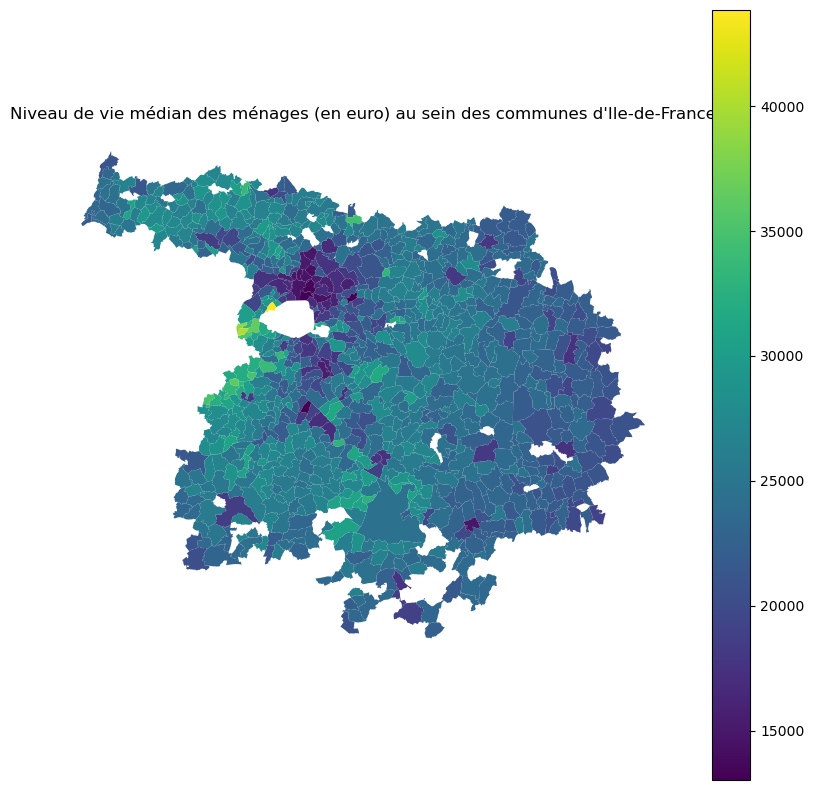

In [24]:
ax = Filosofi_dpe_IDF_com4.plot(figsize=(10,10), column = 'MED16', legend = True)
plt.title("Niveau de vie médian des ménages (en euro) au sein des communes d'Ile-de-France")
ax.set_axis_off()

## D) Création de la carte statique n°2: la proportion de logements énergivores

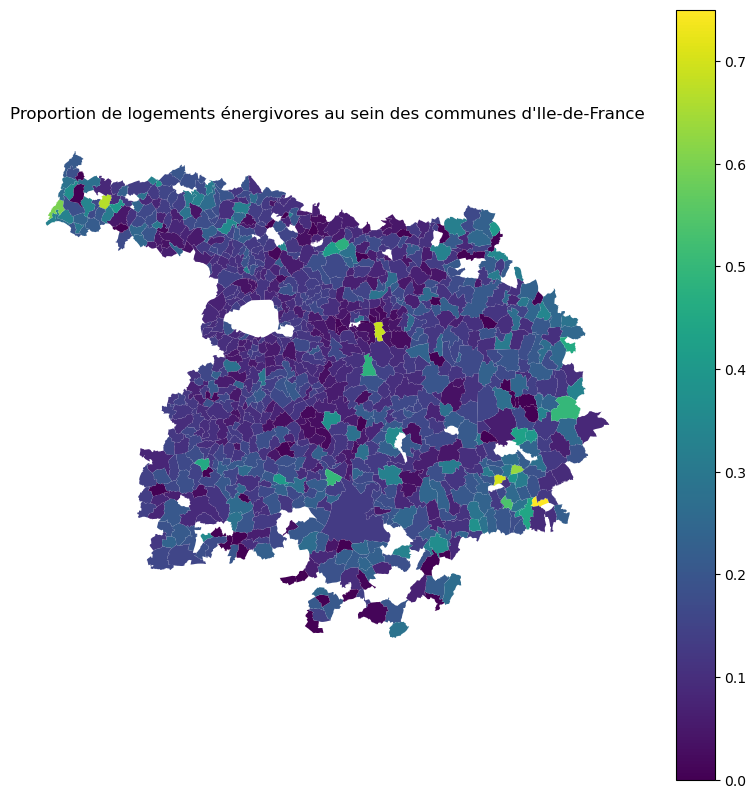

In [23]:
ax = Filosofi_dpe_IDF_com4.plot(figsize=(10,10), column = 'proportion_energivores', legend = True)
plt.title("Proportion de logements énergivores au sein des communes d'Ile-de-France")
ax.set_axis_off()